In [137]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

import ipywidgets as widgets

In [138]:
%matplotlib inline

In [139]:
def show(imgs, titles=None, cols=None, rows=None, cmap='gray', figsize=None):
    """
    Универсальная рисовалка.
    imgs: одна картинка или список картинок
    titles: один заголовок или список заголовков
    cols, rows: количество столбцов и строк (если None - вычисляется авто)
    """
    # Нормализация ввода (делаем списки, даже если пришел один объект)
    if not isinstance(imgs, list):
        imgs = [imgs]
    if titles is not None and not isinstance(titles, list):
        titles = [titles]

    n = len(imgs)

    # Авторасчет сетки
    if cols is None and rows is None:
        cols = n
        rows = 1
    elif cols is None:
        cols = (n + rows - 1) // rows
    elif rows is None:
        rows = (n + cols - 1) // cols

    # Авторасчет размера фигуры
    if figsize is None:
        figsize = (5 * cols, 5 * rows)

    plt.figure(figsize=figsize)

    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)

        # Если картинка цветная (3 канала), cmap игнорируем, чтобы цвета не исказились
        current_cmap = cmap
        if len(img.shape) == 3:
            current_cmap = None

        plt.imshow(img, cmap=current_cmap)

        if titles and i < len(titles):
            plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [140]:
# Загрузка изображений
img_mnist = cv2.imread('mnist_3.png', cv2.IMREAD_GRAYSCALE)
img_lenna = cv2.imread('lenna.png')
img_lenna = cv2.cvtColor(img_lenna, cv2.COLOR_BGR2RGB)
img_baboon = cv2.imread('baboon.jpg', cv2.IMREAD_GRAYSCALE)
img_s1r = cv2.imread('s1r.jpg')
img_s1r = cv2.cvtColor(img_s1r, cv2.COLOR_BGR2RGB)
img_chess = cv2.imread('chess.jpg')
img_zombie = cv2.imread('mine_zombie.jpg')

In [141]:
# Реализация через numpy stride_tricks (без лишних циклов Python)
def fast_custom_mean_filter(data, filter_size=3):
    pad = filter_size // 2
    # Паддинг константой (0)
    padded = np.pad(data, pad, mode='constant')

    # Создаем view окон
    windows = np.lib.stride_tricks.sliding_window_view(padded, (filter_size, filter_size))

    # Считаем среднее по осям окна
    result = windows.mean(axis=(2, 3))
    return result

In [142]:
# Тест
start_time = time.time()
res_my = fast_custom_mean_filter(img_mnist, 5)
print(f"Время выполнения (custom): {time.time() - start_time:.5f} сек")

Время выполнения (custom): 0.00082 сек


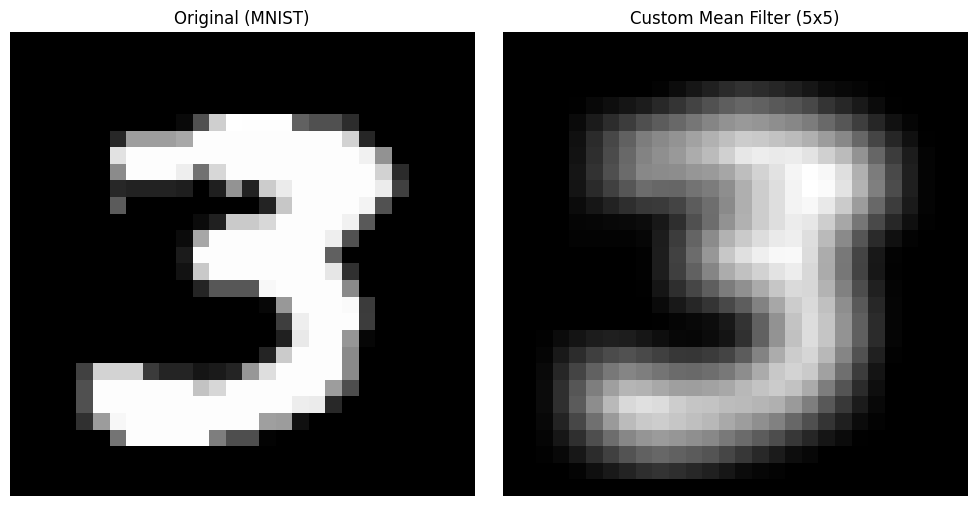

In [143]:
show([img_mnist, res_my],
     ["Original (MNIST)", "Custom Mean Filter (5x5)"])

In [144]:
def check_scharr():
    # Ядро Шарра по X
    kernel_x = np.array([[-3, 0, 3],
                         [-10, 0, 10],
                         [-3, 0, 3]])

    # Применяем фильтр
    grad_x = cv2.filter2D(img_lenna, cv2.CV_64F, kernel_x)
    grad_x_abs = cv2.convertScaleAbs(grad_x)

    # Вывод одной картинки
    show(grad_x_abs, "Scharr X Operator")

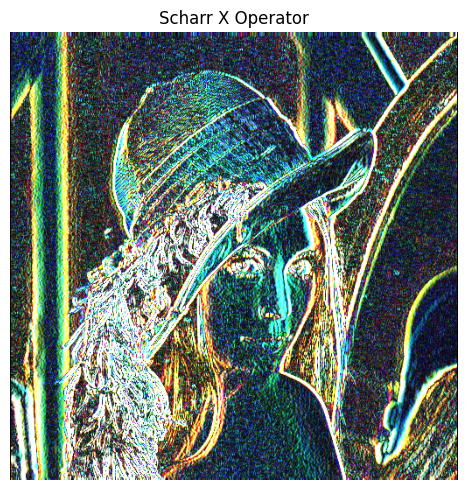

In [145]:
check_scharr()

In [146]:
def salt_and_pepper(image, prob=0.05):
    output = np.copy(image)
    h, w = image.shape[:2]
    # Соль
    num_salt = np.ceil(prob * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in (h, w)]
    output[coords[0], coords[1], :] = 255
    # Перец
    num_pepper = np.ceil(prob * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in (h, w)]
    output[coords[0], coords[1], :] = 0
    return output

In [147]:
# Генерация
noisy = salt_and_pepper(img_lenna, 0.05)
median = cv2.medianBlur(noisy, 5)
bilateral = cv2.bilateralFilter(noisy, 9, 75, 75)

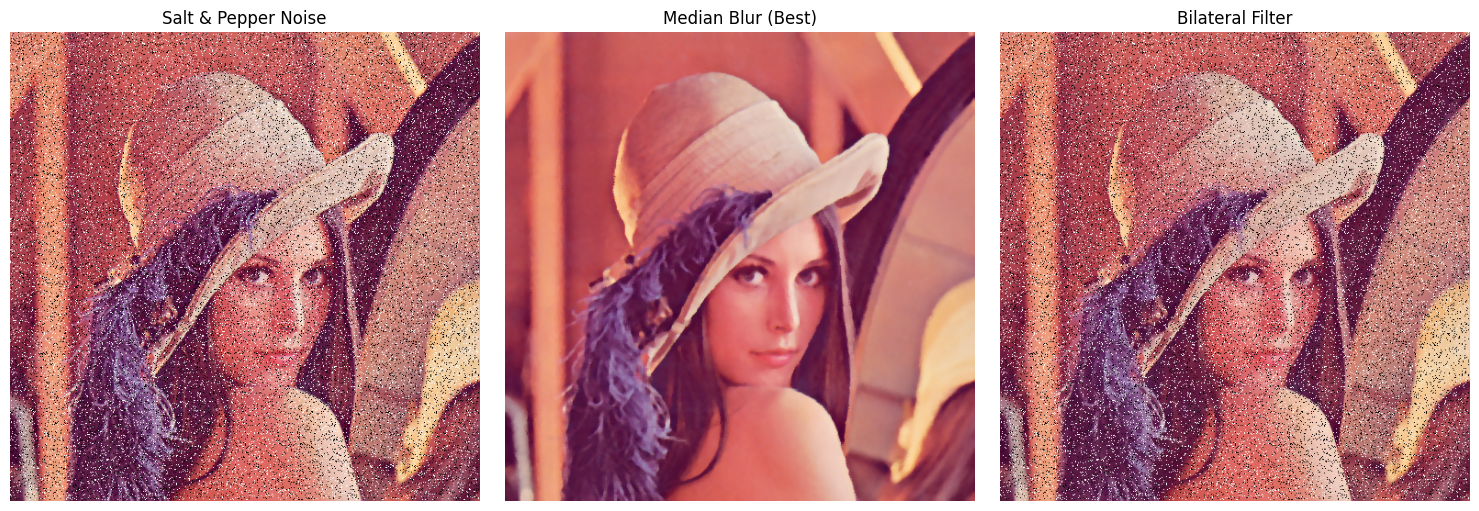

In [148]:
# Вывод 3-х изображений в 1 строку
show([noisy, median, bilateral],
     ["Salt & Pepper Noise", "Median Blur (Best)", "Bilateral Filter"],
     cols=3)

In [149]:
# Sobel
sobel_xx = cv2.Sobel(img_baboon, cv2.CV_64F, 2, 0, ksize=3)
sobel_yy = cv2.Sobel(img_baboon, cv2.CV_64F, 0, 2, ksize=3)
sum_sobel = sobel_xx + sobel_yy

In [150]:
# Laplacian
laplacian = cv2.Laplacian(img_baboon, cv2.CV_64F, ksize=3)
laplacian_view = cv2.convertScaleAbs(laplacian)

In [151]:
diff = np.abs(sum_sobel - laplacian)
print(f"Mean diff: {np.mean(diff)}")

Mean diff: 0.0


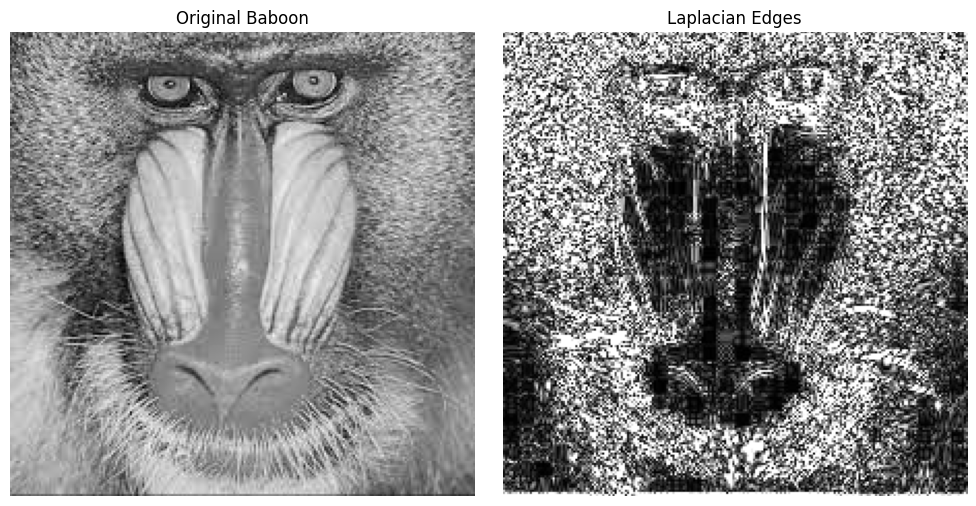

In [152]:
show([img_baboon, laplacian_view],
     ["Original Baboon", "Laplacian Edges"])

In [153]:
@widgets.interact(
    low=(0, 255, 1),
    ratio=(1.0, 5.0, 0.1),
    blur=(1, 15, 2),
    aperture=widgets.IntSlider(min=3, max=7, step=2, value=3),
    l2=False
)
def interactive_canny(low=100, ratio=2, blur=3, aperture=3, l2=False):
    # Сглаживание
    if blur > 0:
        blurred = cv2.GaussianBlur(img_lenna, (blur, blur), 0)
    else:
        blurred = img_lenna

    high = low * ratio
    edges = cv2.Canny(blurred, low, high, apertureSize=aperture, L2gradient=l2)

    # Выводим через нашу функцию
    show(edges, f"Canny: {low} / {int(high)}")

interactive(children=(IntSlider(value=100, description='low', max=255), FloatSlider(value=2.0, description='ra…

In [154]:
gray_s1r = cv2.cvtColor(img_s1r, cv2.COLOR_RGB2GRAY)
gray_s1r = cv2.blur(gray_s1r, (3,3))
edges_s1r = cv2.Canny(gray_s1r, 50, 150)

In [155]:
contours, _ = cv2.findContours(edges_s1r, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [156, 156, 156],
        [172, 172, 172]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [158, 158, 158],
        [166, 166, 166]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [167, 167, 167],
        [164, 164, 164]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
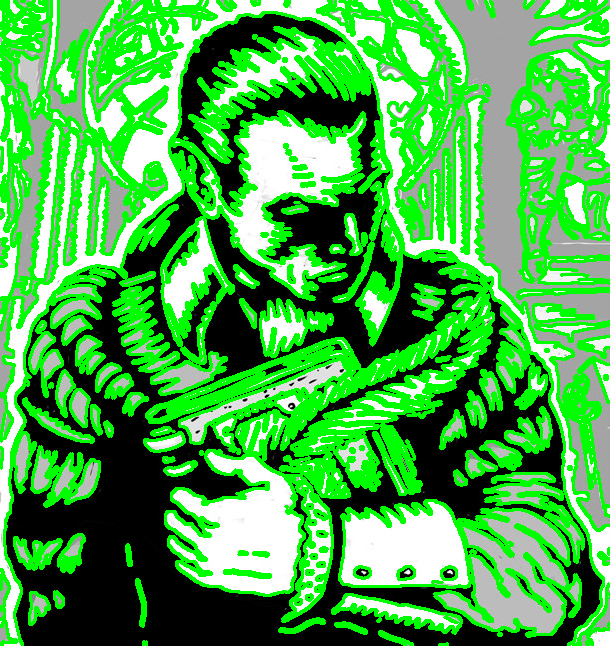

In [156]:
res_cont = img_s1r.copy()
cv2.drawContours(res_cont, contours, -1, (0, 255, 0), 2)

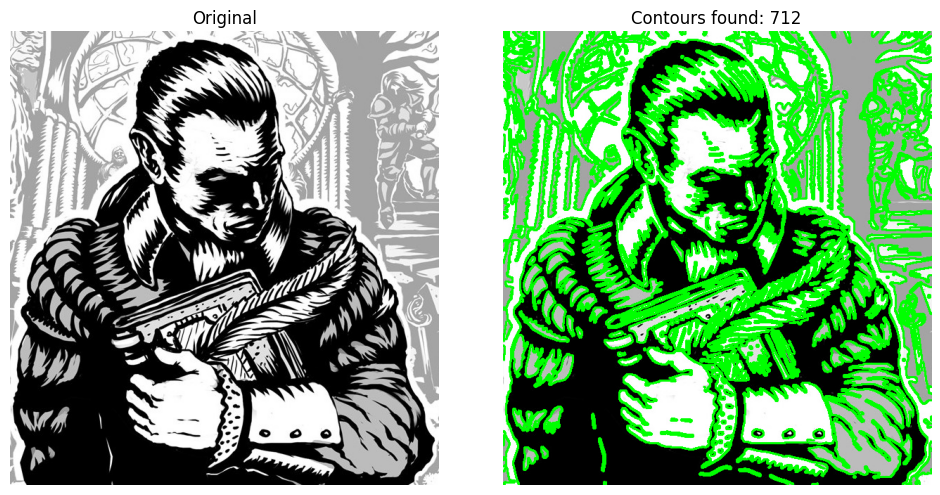

In [157]:
show([img_s1r, res_cont],
     ["Original", f"Contours found: {len(contours)}"])

In [158]:
def process_corners(img_bgr, title):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Поиск углов
    corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.01, minDistance=10)
    if corners is None: return
    corners = np.float32(corners)

    # Субпиксельное уточнение
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners_sub = cv2.cornerSubPix(gray, corners, (5,5), (-1,-1), criteria)

    # Рисование
    res = img_bgr.copy()
    for i in range(corners.shape[0]):
        x, y = corners[i].ravel()
        cv2.circle(res, (int(x), int(y)), 5, (0, 0, 255), -1) # Красные точки

        x2, y2 = corners_sub[i].ravel()
        cv2.drawMarker(res, (int(x2), int(y2)), (0, 255, 0), markerType=cv2.MARKER_CROSS, markerSize=10, thickness=2) # Зеленые кресты

    return cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

In [159]:
# Обработка
res_chess = process_corners(img_chess, "Chess")
res_zombie = process_corners(img_zombie, "Zombie")

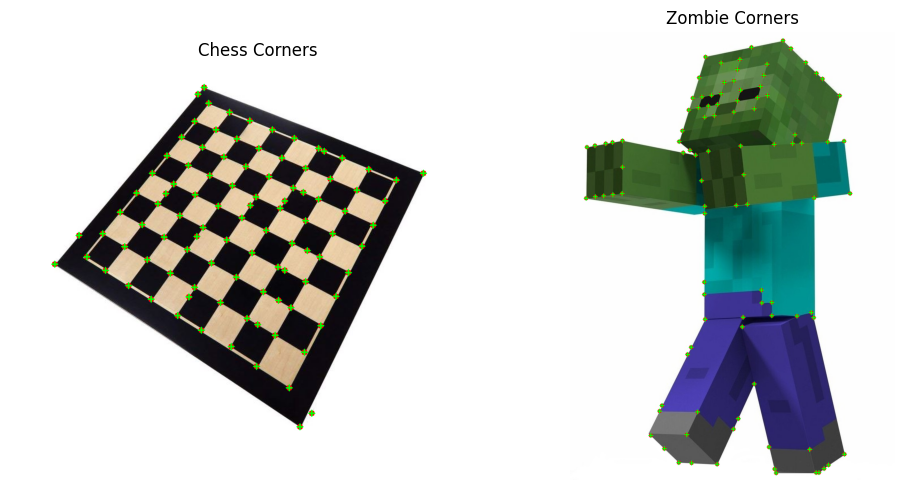

In [160]:
show([res_chess, res_zombie],
     ["Chess Corners", "Zombie Corners"])

In [161]:
def get_match_image(train_path, query_path):
    img_train = cv2.imread(train_path, 0)
    img_query = cv2.imread(query_path, 0)

    orb = cv2.ORB_create(nfeatures=1000)
    kp1, des1 = orb.detectAndCompute(img_train, None)
    kp2, des2 = orb.detectAndCompute(img_query, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = sorted(bf.match(des1, des2), key=lambda x: x.distance)

    res = cv2.drawMatches(img_train, kp1, img_query, kp2, matches[:20], None, flags=2)
    return res

In [162]:
# Собираем результаты
base = 'naturmort_1.jpg'
queries = ['naturmort_2_1.jpg', 'naturmort_2_2.jpg', 'naturmort_2_4.jpg']
results = [get_match_image(base, q) for q in queries]
titles = [f"Match with {q}" for q in queries]

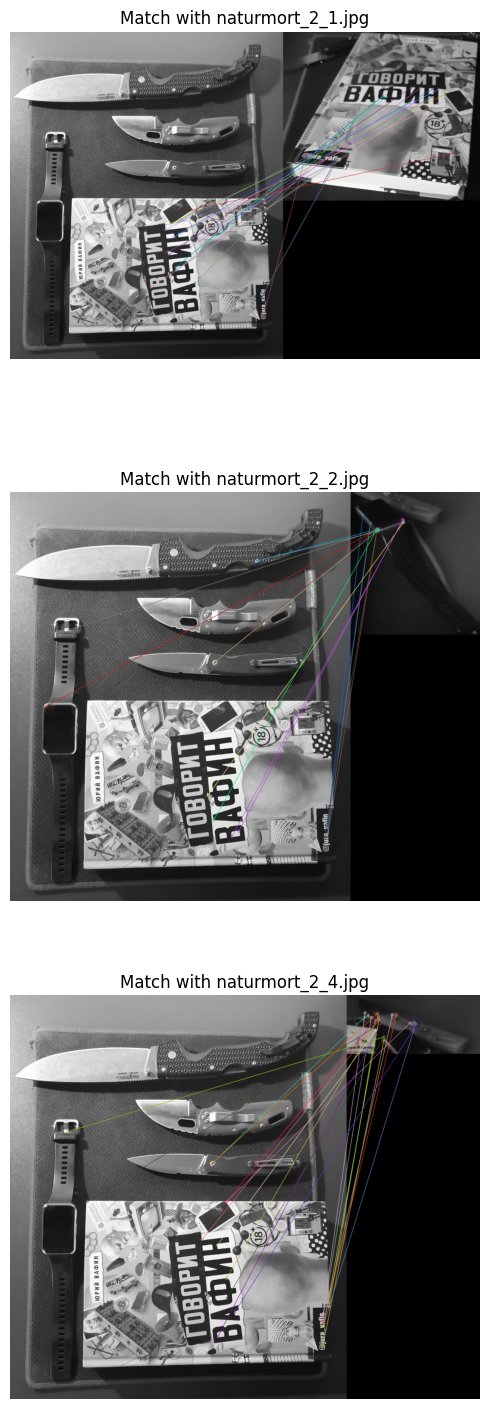

In [163]:
# Выводим в 1 столбец, 3 строки (чтобы было крупно)
show(results, titles, cols=1)